In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import torch
from torch.nn import Linear, ReLU, Sigmoid, Parameter

import torch_geometric
from torch_geometric.nn import Sequential, GCNConv, SimpleConv, MessagePassing

from pathpyG.core.Graph import Graph
from pathpyG.io.netzschleuder import read_netzschleuder_network

We can read networks from the netzschleuder database:

In [2]:
g = read_netzschleuder_network('software_dependencies', 'jdk')
g.add_node_ohe('node_ohe')
print(g)

Graph with 6488 nodes and 150985 edges

Node attributes
	node__pos		<class 'torch.Tensor'> -> torch.Size([6488, 1, 2])
	node_ohe		<class 'torch.Tensor'> -> torch.Size([6488, 6488])

Graph attributes
	description		<class 'str'>
	name		<class 'str'>
	node_id		<class 'list'>
	url		<class 'str'>
	tags		<class 'list'>
	citation		<class 'list'>



c:\Users\Ingo Scholtes\Documents\repos\pathpyNG\pathpyG\io\netzschleuder.py:297: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  g.data['node_{0}'.format(a)] = torch.tensor(node_attr[a], dtype=torch.float)


In [3]:
g = read_netzschleuder_network('karate', '77')
g.add_node_ohe('node_ohe')
print(g)

Graph with 34 nodes and 77 edges

Node attributes
	node_groups		<class 'torch.Tensor'> -> torch.Size([34, 1])
	node__pos		<class 'torch.Tensor'> -> torch.Size([34, 1, 2])
	node_name		<class 'torch.Tensor'> -> torch.Size([34, 1])
	node_ohe		<class 'torch.Tensor'> -> torch.Size([34, 34])

Graph attributes
	description		<class 'str'>
	name		<class 'str'>
	node_id		<class 'list'>
	url		<class 'str'>
	tags		<class 'list'>
	citation		<class 'str'>



In [4]:
print(g['node_groups'])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]])


Let us shift this to values 0 and 1: 

In [5]:
g['node_groups'] -= 1

In [6]:
print(g['node_groups'])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [7]:
print(g.data)

Data(edge_index=[2, 77], node_id=[0], node_name=[34, 1], node_groups=[34, 1], node__pos=[34, 1, 2], name='karate (77)', description='Network of friendships among members of a university karate club. Includes metadata for faction membership after a social partition. Note: there are two versions of this network, one with 77 edges and one with 78, due to an ambiguous typo in the original study. (The most commonly used is the one with 78 edges.)[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.', citation='['W. W. Zachary, "An information flow model for conflict and fission in small groups." Journal of Anthropological Research 33, 452-473 (1977)., https://doi.org/10.1086/jar.33.4.3629752']', url='https://aaronclauset.github.io/datacode.htm', tags=[3], node_ohe=[34, 34])


In [8]:
data = g.data
data['x'] = data['node_ohe']
data['y'] = data['node_groups']

We can now apply a GCN to the Karate club network:

In [9]:
model = Sequential('node_ohe, edge_index', [
    (GCNConv(in_channels=data.num_node_features, out_channels=8), 'node_ohe, edge_index -> node_ohe'),
    ReLU(inplace=True),
    (GCNConv(in_channels=8, out_channels=1), 'node_ohe, edge_index -> node_ohe'),
    Sigmoid(),
])
print([p for p in model.parameters()])

[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-1.4953e-01, -1.9538e-01, -1.4405e-02, -2.2094e-01,  3.1998e-01,
         -3.2377e-01, -1.3245e-01, -2.1982e-01,  2.1005e-01, -1.7053e-01,
         -2.5171e-02,  2.3923e-01,  6.0778e-02,  7.4697e-02,  1.5988e-01,
         -9.3242e-02,  2.0909e-01,  3.4580e-01,  2.7030e-01, -3.3579e-01,
          2.9126e-01,  2.7869e-01, -3.1540e-01,  2.5103e-02,  3.4120e-01,
         -3.7126e-01,  1.7414e-01, -1.1898e-01,  2.0420e-01, -2.1922e-01,
          3.5889e-01, -2.4899e-01, -2.3409e-01, -8.4862e-02],
        [ 2.5669e-01, -3.4922e-01,  2.9398e-01, -1.9694e-01, -1.9047e-01,
          1.9192e-01,  8.3498e-02,  1.1418e-01,  3.4961e-01,  3.1728e-01,
          2.3541e-02, -2.0665e-01, -2.1431e-01,  3.6105e-01,  9.5354e-03,
          8.1303e-02,  2.5295e-01,  1.3512e-01,  1.1161e-01,  2.4419e-01,
          3.1029e-01,  1.6195e-01, -2.9475e-01, -7.1086e-02,  1.6644e-01,
         -5.7623e

In [10]:
transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.5, num_test=0)
transform(data)

Data(edge_index=[2, 77], node_id=[0], node_name=[34, 1], node_groups=[34, 1], node__pos=[34, 1, 2], name='karate (77)', description='Network of friendships among members of a university karate club. Includes metadata for faction membership after a social partition. Note: there are two versions of this network, one with 77 edges and one with 78, due to an ambiguous typo in the original study. (The most commonly used is the one with 78 edges.)[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.', citation='['W. W. Zachary, "An information flow model for conflict and fission in small groups." Journal of Anthropological Research 33, 452-473 (1977)., https://doi.org/10.1086/jar.33.4.3629752']', url='https://aaronclauset.github.io/datacode.htm', tags=[3], node_ohe=[34, 34], x=[34, 34], y=[34, 1], train_mask=[34], val_mask=[34], test_mask=[34])

In [11]:
epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

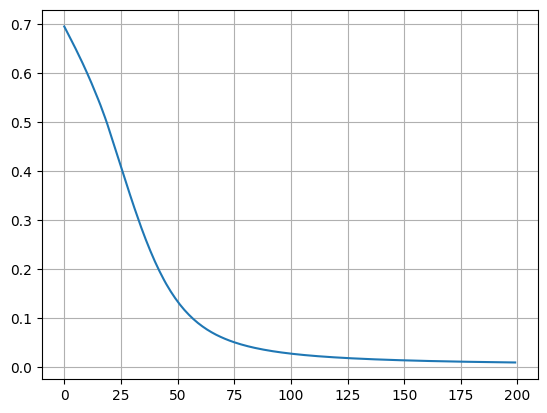

In [12]:
plt.plot(range(epochs), losses)
plt.grid()

We evaluate the model in the test set

In [13]:
model.eval()
predicted_groups = model(data.x, data.edge_index).round().long()
metrics.adjusted_mutual_info_score(data.y[data.test_mask].squeeze().numpy(), predicted_groups[data.test_mask].squeeze().numpy())

1.0

We visualize node representations learned by the model.

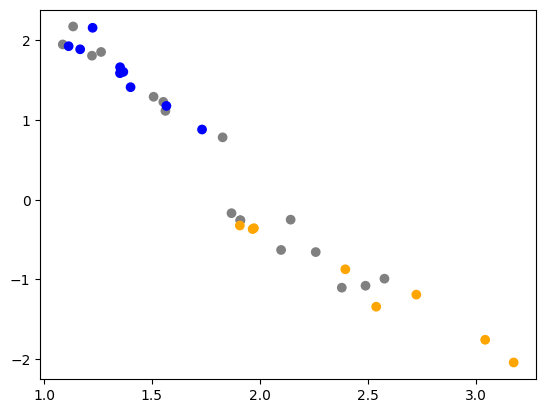

In [14]:
# get activations in first-layer
embedding = model[0].forward(data.x, data.edge_index)

# dimensionality reduction
svd = TruncatedSVD()
low_dim = svd.fit_transform(embedding.detach().numpy())

# plot with colors corresponding to groups in validation set
colors = {}
for v in range(g.N):
    if data.val_mask[v]:
        colors[v] = 'grey'
    else:
        if data.y[v].item() == 0.0:
            colors[v] = 'blue'
        else:
            colors[v] = 'orange'

plt.scatter(low_dim[:,0], low_dim[:,1], c=colors.values());

In [107]:
from torch_geometric.utils import degree, to_undirected

In [99]:
g.data['node_degree'] = degree(g.data.edge_index[1])
print(g.data['node_degree'])

tensor([0., 1., 2., 3., 1., 1., 3., 4., 2., 1., 3., 1., 2., 4., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 3., 3., 2., 2., 1., 2., 3., 2., 1., 4., 9.])


In [110]:
data = g.data
data['edge_index'] = to_undirected(data.edge_index)
data['x'] = torch.tensor([1.0]*34).reshape(34,1)
data['y'] = degree(data.edge_index[1]).reshape(34,1)
print(data['x'])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [111]:
class AggConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=True)
        #self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        #self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 2: Start propagating messages.
        out = self.propagate(edge_index, x=x)

        # Step 6: Apply a final bias vector.
       # out += self.bias

        return out

    def message(self, x_j):
        return x_j

In [112]:
model = Sequential('node_degree, edge_index', [
    (AggConv(in_channels=data.num_node_features, out_channels=1), 'node_degree, edge_index -> node_degree')
])
print([p for p in model.parameters()])

[Parameter containing:
tensor([[-0.8718]], requires_grad=True), Parameter containing:
tensor([-0.6876], requires_grad=True)]


In [113]:
transform = torch_geometric.transforms.RandomNodeSplit(split='train_rest', num_val=0.5, num_test=0)
transform(data)

Data(edge_index=[2, 154], node_id=[0], node_name=[34, 1], node_groups=[34, 1], node__pos=[34, 1, 2], name='karate (77)', description='Network of friendships among members of a university karate club. Includes metadata for faction membership after a social partition. Note: there are two versions of this network, one with 77 edges and one with 78, due to an ambiguous typo in the original study. (The most commonly used is the one with 78 edges.)[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.', citation='['W. W. Zachary, "An information flow model for conflict and fission in small groups." Journal of Anthropological Research 33, 452-473 (1977)., https://doi.org/10.1086/jar.33.4.3629752']', url='https://aaronclauset.github.io/datacode.htm', tags=[3], node_ohe=[34, 34], x=[34, 1], y=[34, 1], train_mask=[34], val_mask=[34], test_mask=[34], node_degree=[34])

In [115]:
epochs = 2500

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.l1_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy())

print([p for p in model.parameters()])

[Parameter containing:
tensor([[0.4086]], requires_grad=True), Parameter containing:
tensor([0.5924], requires_grad=True)]


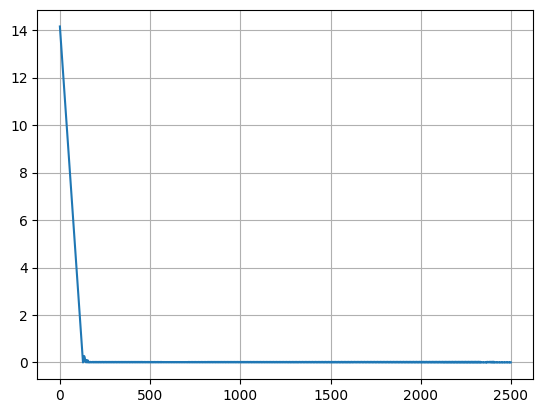

In [116]:
plt.plot(range(epochs), losses)
plt.grid()

In [117]:
model.eval()
predicted_degrees = model(data.x, data.edge_index).detach()
metrics.mean_absolute_error(data.y[data.val_mask].squeeze().numpy(), predicted_degrees[data.val_mask].squeeze().numpy())

0.0033248172

In [118]:
model(data.x, data.edge_index)

tensor([[16.0151],
        [ 9.0085],
        [10.0094],
        [ 6.0057],
        [ 3.0028],
        [ 4.0038],
        [ 4.0038],
        [ 4.0038],
        [ 5.0047],
        [ 2.0019],
        [ 3.0028],
        [ 1.0009],
        [ 2.0019],
        [ 5.0047],
        [ 2.0019],
        [ 2.0019],
        [ 2.0019],
        [ 2.0019],
        [ 2.0019],
        [ 3.0028],
        [ 2.0019],
        [ 2.0019],
        [ 1.0009],
        [ 5.0047],
        [ 3.0028],
        [ 3.0028],
        [ 2.0019],
        [ 4.0038],
        [ 3.0028],
        [ 4.0038],
        [ 4.0038],
        [ 6.0057],
        [12.0113],
        [16.0151]], grad_fn=<ScatterAddBackward0>)

In [119]:
data.y

tensor([[16.],
        [ 9.],
        [10.],
        [ 6.],
        [ 3.],
        [ 4.],
        [ 4.],
        [ 4.],
        [ 5.],
        [ 2.],
        [ 3.],
        [ 1.],
        [ 2.],
        [ 5.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 3.],
        [ 2.],
        [ 2.],
        [ 1.],
        [ 5.],
        [ 3.],
        [ 3.],
        [ 2.],
        [ 4.],
        [ 3.],
        [ 4.],
        [ 4.],
        [ 6.],
        [12.],
        [16.]])